# EPA1361 - Model-Based Decision Making
# Week 3 - Sensitivity analysis

This exercise uses the same predator-prey model we used for the multi-model exercise, focusing on the Python version. As with the other exercise, define a model object for the function below, with the uncertainty ranges provided:

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |

* Sensitivity analysis often focuses on the final values of an outcome at the end of the simulation. However, we can also look at metrics that give us additional information about the behavior of the model over time. Using [the statsmodel library](https://www.statsmodels.org/stable/index.html) and an appropriate sampling design, fit a linear regression model for each of the following indicators. What can we conclude about the behavior of the model, and about the importance of the different inputs?

  * The final values of the _prey_ outcome
  * The mean values of the _prey_ outcome over time, within each experiment
  * The standard deviations of the _prey_ outcome over time, within each experiment


## 1. The Pred Prey Function

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments, ema_logging)

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol

def pred_prey(prey_birth_rate=0.025, predation_rate=0.0015, predator_efficiency=0.002,
             predator_loss_rate=0.06, initial_prey=50, initial_predators=20, dt=0.25, 
             final_time=365, reps=1):

    #Initial values
    predators = np.zeros((reps, int(final_time/dt)+1))
    prey = np.zeros((reps, int(final_time/dt)+1))
    sim_time = np.zeros((reps, int(final_time/dt)+1))
    
    for r in range(reps):

        predators[r,0] = initial_predators
        prey[r,0] = initial_prey

    #Calculate the time series
    for t in range(0, sim_time.shape[1]-1):

        dx = (prey_birth_rate*prey[r,t]) - (predation_rate*prey[r,t]*predators[r,t])
        dy = (predator_efficiency*predators[r,t]*prey[r,t]) - (predator_loss_rate*predators[r,t])

        prey[r,t+1] = max(prey[r,t] + dx*dt, 0)
        predators[r,t+1] = max(predators[r,t] + dy*dt, 0)
        sim_time[r,t+1] = (t+1)*dt
    
    #Return outcomes
    return {'TIME':sim_time,
            'predators':predators,
            'prey':prey}

C:\Users\sahit\Anaconda\lib\site-packages\ema_workbench\em_framework\optimization.py:48: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)


## 2. Pred Prey model

In [2]:
ema_logging.log_to_stderr(ema_logging.INFO)

#We can define common uncertainties and outcomes for each model:
uncertainties = [RealParameter('prey_birth_rate', 0.015, 0.035),
                 RealParameter('predation_rate', 0.0005, 0.003),
                 RealParameter('predator_efficiency', 0.001, 0.004),
                 RealParameter('predator_loss_rate', 0.04, 0.08)] 

#np.squeexe gets a single dimension array 
outcomes = [TimeSeriesOutcome('TIME', function=np.squeeze),
            TimeSeriesOutcome('predators', function=np.squeeze),
            TimeSeriesOutcome('prey', function=np.squeeze)]


#Define the Python model
py_model = Model('Python', function=pred_prey)
py_model.uncertainties = uncertainties
py_model.outcomes = outcomes

## 3. Linear Regression Model

In [3]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [4]:
nr_experiments = 50

#Using Latin Hypercube sampling
experiments, outcomes = perform_experiments(py_model, nr_experiments, uncertainty_sampling=LHS)

[MainProcess/INFO] performing 50 scenarios * 1 policies * 1 model(s) = 50 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 5 cases completed
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 15 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 25 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 35 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 45 cases completed
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] experiments finished


In [5]:
outcome_prey = outcomes['prey'][:,-1]
experiments_lm = np.asarray(experiments.select_dtypes(exclude=['object']))

In [6]:
results = sm.OLS(outcome_prey, experiments_lm).fit()

In [8]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.778
Model:                            OLS   Adj. R-squared (uncentered):              0.759
Method:                 Least Squares   F-statistic:                              40.27
Date:                Fri, 15 May 2020   Prob (F-statistic):                    1.77e-14
Time:                        14:04:47   Log-Likelihood:                         -213.12
No. Observations:                  50   AIC:                                      434.2
Df Residuals:                      46   BIC:                                      441.9
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           500.7201   3301.943      0.152      0.880   -6145.746    7147.186
x2          -1.12e+04   2642.871     -4.238      0.000   -1.65e+04   -5880.283
x3           695.4064    161.348      4.310      0.000     370.629    1020.183
x4           581.2045    340.247      1.708      0.094    -103.677    1266.086
==============================================================================
Omnibus:                        1.004   Durbin-Watson:                   2.191
Prob(Omnibus):                  0.605   Jarque-Bera (JB):                1.066
Skew:                           0.272   Prob(JB):                        0.587
Kurtosis:                       2.537   Cond. No.                         89.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
outcome_prey_mean = np.mean(outcomes['prey'], axis = 1)
experiments_lm = np.asarray(experiments.select_dtypes(exclude=['object']))

In [10]:
results_mean = sm.OLS(outcome_prey_mean, experiments_lm).fit()

In [11]:
results_mean.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.965
Model:                            OLS   Adj. R-squared (uncentered):              0.962
Method:                 Least Squares   F-statistic:                              315.4
Date:                Fri, 15 May 2020   Prob (F-statistic):                    8.54e-33
Time:                        14:04:47   Log-Likelihood:                         -156.92
No. Observations:                  50   AIC:                                      321.8
Df Residuals:                      46   BIC:                                      329.5
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           160.8208   1073.094      0.150      0.882   -1999.206    2320.848
x2         -1.051e+04    858.903    -12.241      0.000   -1.22e+04   -8785.269
x3           615.6013     52.436     11.740      0.000     510.052     721.150
x4           616.4729    110.576      5.575      0.000     393.894     839.052
==============================================================================
Omnibus:                        7.614   Durbin-Watson:                   2.306
Prob(Omnibus):                  0.022   Jarque-Bera (JB):                6.700
Skew:                           0.741   Prob(JB):                       0.0351
Kurtosis:                       4.011   Cond. No.                         89.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
outcome_prey_stdev = np.std(outcomes['prey'], axis = 1)
experiments_lm = np.asarray(experiments.select_dtypes(exclude=['object']))

In [13]:
results_stdev = sm.OLS(outcome_prey_stdev, experiments_lm).fit()

In [14]:
results_stdev.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.961
Model:                            OLS   Adj. R-squared (uncentered):              0.958
Method:                 Least Squares   F-statistic:                              286.0
Date:                Fri, 15 May 2020   Prob (F-statistic):                    7.43e-32
Time:                        14:04:47   Log-Likelihood:                         -122.98
No. Observations:                  50   AIC:                                      254.0
Df Residuals:                      46   BIC:                                      261.6
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          1376.6114    544.242      2.529      0.015     281.109    2472.114
x2          2038.5158    435.611      4.680      0.000    1161.677    2915.355
x3            39.8800     26.594      1.500      0.141     -13.651      93.411
x4           162.5894     56.081      2.899      0.006      49.704     275.475
==============================================================================
Omnibus:                        1.847   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.397   Jarque-Bera (JB):                1.146
Skew:                          -0.350   Prob(JB):                        0.564
Kurtosis:                       3.243   Cond. No.                         89.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Conclusions
x1: predation rate
x2: predator efficiency
x3: predator loss rate
x4: prey birth rate

predation rate
- It can be seen that the sensitivity prey to predation rate is highly variable. It cannot be concluded that the predation rate effects the last value or mean value of prey. 
- However, it can be said that the predation rate has an effect on the standard deviation of prey. 

Predator efficiency
- It can said that the effect of predator efficiency on prey is negative. However, given the high confidence range, the effect cannot be estimated. 

predator loss rate 
- predator loss rate has a positive correlation with mean and last value of prey

prey birth rate
- The effect of this cannot be determined meaningfully from this regression. The sensitivity of the mean value of prey can be estimated with more confidence as positive. 

- Birth rate, predation rate and predator loss rate also affect the standard deviation of prey. 

## 4. SOBOL


* Use the Sobol sampling functionality included in the Workbench to perform experiments with a sample size of N=50, then analyze the results with SALib for the same three indicators. This requires specifying the keyword argument `'uncertainty_sampling'` of perform_experiments. 

Note that when using Sobol sampling, the meaning of the keyword argument `scenarios` changes a bit. In order to properly estimate Sobol scores as well as interaction effects, you require N * (2D+2) scenarios, where D is the number of uncertain parameters, and N is the value for scenarios passed to `perform_experiments`. Repeat the analysis for larger sample sizes, with N=250 and N=1000. 

How can we interpret the first-order and total indices? Are these sample sizes sufficient for a stable estimation of the indices? 

You'll need to use the [get_SALib_problem](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/em_framework/salib_samplers.html) function to convert your Workbench experiments to a problem definition that you can pass to the SALib analysis function. 

* *hint*: sobol is a deterministic sequence of quasi random numbers. Thus, you can run with N=1000 and simply slice for 1:50 and 1:250.

In [15]:
from ema_workbench.em_framework import salib_samplers

In [16]:
from ema_workbench import SequentialEvaluator

In [17]:
n_scenarios = 1000

ema_logging.log_to_stderr(ema_logging.INFO)

with SequentialEvaluator(py_model) as evaluator: 
    results_sobol = evaluator.perform_experiments(n_scenarios, uncertainty_sampling=SOBOL)

[MainProcess/INFO] performing 10000 scenarios * 1 policies * 1 model(s) = 10000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7000 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] 9000 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] experiments finished


In [18]:
experiments_sobol, outcomes_sobol = results_sobol

In [19]:
problem = get_SALib_problem(py_model.uncertainties)
y = outcomes_sobol['prey'][:,-1]
y_mean = np.mean(outcomes_sobol['prey'], axis = 1)
y_std = np.std(outcomes_sobol['prey'], axis = 1)

sobol_indices = sobol.analyze(problem, y)
sobol_indices_mean = sobol.analyze(problem, y_mean)
sobol_indices_std = sobol.analyze(problem, y_std)

In [21]:
y_n50 = outcomes_sobol['prey'][:,-1][0:500]
sobol_indices_n50 = sobol.analyze(problem, y_n50)

In [24]:
pd.concat([sobol_indices_n50.to_df()[0],sobol_indices_n50.to_df()[1]], axis =1) 

,ST,ST_conf,S1,S1_conf
predation_rate,0.127158,0.099256,0.093433,0.122786
predator_efficiency,0.861776,0.415875,0.467832,0.376621
predator_loss_rate,0.586328,0.302995,0.106056,0.221582
prey_birth_rate,0.509988,0.259831,0.067219,0.344418


In [25]:
y_n250 = outcomes_sobol['prey'][:,-1][0:2500]
sobol_indices_n250 = sobol.analyze(problem, y_n250)

In [28]:
sobol_indices_df = pd.concat([sobol_indices.to_df()[0], sobol_indices.to_df()[1]], axis =1)
sobol_indices_df = sobol_indices_df.reset_index()
sobol_indices_df

,index,ST,ST_conf,S1,S1_conf
0,predation_rate,0.132785,0.025721,-0.002546,0.035346
1,predator_efficiency,0.809377,0.098546,0.407665,0.079364
2,predator_loss_rate,0.585974,0.069688,0.079809,0.055449
3,prey_birth_rate,0.511565,0.052239,0.030426,0.052868


In [27]:
pd.concat([sobol_indices_n250.to_df()[0],sobol_indices_n250.to_df()[1]], axis =1) 

,ST,ST_conf,S1,S1_conf
predation_rate,0.123294,0.041149,0.054258,0.053363
predator_efficiency,0.852120,0.158538,0.279763,0.149006
predator_loss_rate,0.606673,0.108174,0.017445,0.114763
prey_birth_rate,0.565059,0.109437,-0.044853,0.116438


#### Conclusions 
- Overall, prey seems to be most sensitive to predator efficiency.  
- All the variables have a higher total index than their individual indices. This shows the clear presence of intercation within the system.  
- 50 and 250 samples still show a lot of variance. Increasing sample size decreases confidence interval and that can be seen in N_1000 case. 

In [29]:
sobol_indices_mean

{'S1': array([0.00169098, 0.7694395 , 0.17988582, 0.00227352]),
 'S1_conf': array([0.00571382, 0.08423259, 0.04461457, 0.00876925]),
 'ST': array([0.00519748, 0.81717184, 0.21899463, 0.01161008]),
 'ST_conf': array([0.00094389, 0.06914076, 0.02815498, 0.00135313]),
 'S2': array([[        nan, -0.00191167,  0.00315862,  0.00074765],
        [        nan,         nan,  0.05877703,  0.00859264],
        [        nan,         nan,         nan, -0.00722717],
        [        nan,         nan,         nan,         nan]]),
 'S2_conf': array([[       nan, 0.01302889, 0.00916343, 0.00867364],
        [       nan,        nan, 0.14612614, 0.11917758],
        [       nan,        nan,        nan, 0.07251666],
        [       nan,        nan,        nan,        nan]])}

In [30]:
sobol_indices_std

{'S1': array([0.2089077 , 0.09978934, 0.0067359 , 0.05164699]),
 'S1_conf': array([0.07630721, 0.09487347, 0.0479207 , 0.04807519]),
 'ST': array([0.6604275 , 0.62584637, 0.2439193 , 0.28795033]),
 'ST_conf': array([0.12351464, 0.09576909, 0.04823674, 0.06223288]),
 'S2': array([[        nan,  0.17019767,  0.00316671,  0.09303015],
        [        nan,         nan,  0.16278549,  0.01998462],
        [        nan,         nan,         nan, -0.01197096],
        [        nan,         nan,         nan,         nan]]),
 'S2_conf': array([[       nan, 0.12171121, 0.0722275 , 0.1048372 ],
        [       nan,        nan, 0.13295719, 0.13240506],
        [       nan,        nan,        nan, 0.06064949],
        [       nan,        nan,        nan,        nan]])}

## 5. Extra-Trees Analysis

* Use the [Extra-Trees analysis](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/feature_scoring.html) included in the Workbench to approximate the Sobol total indices, with a suitable sampling design. As a starting point, use an ensemble of 100 trees and a max_features parameter of 0.6, and set the analysis to regression mode. Are the estimated importances stable relative to the sample size and the analysis parameters? How do the results compare to the Sobol indices? For more details on this analysis see [Jaxa-Rozen & Kwakkel (2018)](https://www.sciencedirect.com/science/article/pii/S1364815217311581)

In [31]:
import seaborn as sns
import pandas as pd

In [32]:
experiments_cleaned = experiments.select_dtypes(exclude = 'object')

In [33]:
extratrees = feature_scoring.get_ex_feature_scores(experiments_cleaned, outcomes['prey'][:,-1], mode = RuleInductionType.REGRESSION,nr_trees = 100, max_features= 0.6)

In [34]:
extratrees = extratrees[0].reset_index()

In [35]:
ex_sobol = pd.merge(sobol_indices_df, extratrees, left_on = 'index', right_on = 0)
ex_sobol_heatmap = ex_sobol[['index', 'ST', 'S1', 1]]

In [36]:
ex_sobol_heatmap.columns = ['variable', 'Sobol_ST', 'Sobol_S1', 'extratrees']

In [37]:
scores = feature_scoring.get_feature_scores_all(experiments, outcomes)

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


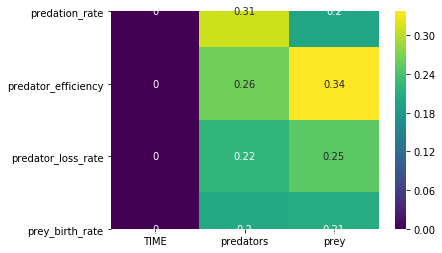

In [38]:
sns.heatmap(scores, annot=True, cmap='viridis')
plt.show()

In [39]:
ex_sobol_heatmap.set_index('variable', inplace=True)

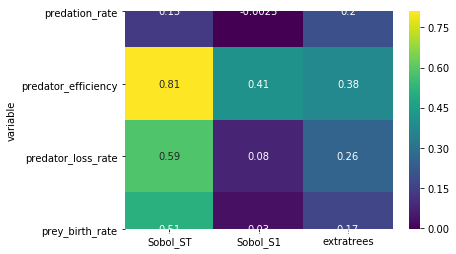

In [40]:
sns.heatmap(ex_sobol_heatmap,annot=True, cmap='viridis')
plt.show()

#### Conclusions
- Prey is most sensitive to Predator efficiency in all tests
- Sobol results show greater sensitivity of prey to prey birth rate in compariosn to extra trees
- The sensitivity of prey to predation rate and prey birth rate are also opposing in extra trees and sobol

Overall, sobol and extra trees capture similar sensitivities except for prey birth rate